In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors

import seaborn as sns
sns.set_style('whitegrid')

/p/software/juwels/stages/2020/software/Jupyter/2021.3.2-gcccoremkl-10.3.0-2021.2.0-Python-3.8.5/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [4]:
def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels

In [5]:
cols = ["P2O5", "K", "Mg", "pH"]

In [6]:
raw_data = '/p/project/hai_cons_ee/data/ai4eo-hyperspectral/raw_data/train_data/'
train_data = os.path.join(raw_data, 'train_data')
test_data = '/p/project/hai_cons_ee/data/ai4eo-hyperspectral/raw_data/test_data/'

X_train = load_data(train_data)
y_train = load_gt(os.path.join(raw_data, "train_gt.csv"))
X_test = load_data(test_data)

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [8]:
def preprocess(X):
    X /= 1850
    X = X.reshape(len(X), 15, 10).mean(axis=-1)

    dXdl = np.gradient(X, axis=1)
    d2Xdl2 = np.gradient(dXdl, axis=1)

    X = np.concatenate((X, dXdl, d2Xdl2), axis=1)
    # X = np.concatenate((X, dXdl), axis=1)

    return X

In [9]:
col_ix = [0,1,2,3]

In [10]:
y_train_col = y_train[:, col_ix] # selected set of labels
print(y_train_col.shape)

(1732, 4)


In [11]:
kfold = KFold(shuffle=True, random_state=2022)
kfold.get_n_splits(X_train, y_train_col)

5

In [12]:
random_forests = []
baseline_regressors = []

y_hat_bl = []
y_hat_rf = []

for ix_train, ix_valid in kfold.split(X_train, y_train_col):

    X_t = X_train[ix_train]
    y_t = y_train_col[ix_train]
    X_v = X_train[ix_valid]
    y_v = y_train_col[ix_valid]

    X_t = preprocess(X_t)
    X_v = preprocess(X_v)

    # baseline

    baseline = BaselineRegressor()
    baseline.fit(X_t, y_t)

    baseline_regressors.append(baseline)

    # random forest

    rf = RandomForestRegressor()
    rf.fit(X_t, y_t)
    print(rf.score(X_v, y_v))

    random_forests.append(rf)
    
    # predictions
    
    y_hat = rf.predict(X_v)
    y_b = baseline.predict(X_v)
    
    y_hat_bl.append(y_b)
    y_hat_rf.append(y_hat)

0.07218213685277433
0.11246938875677356
0.05702878364909161
0.07839573377430295
0.05614859296714417


In [13]:
# for now only the last fold

score = 0

for i in range(4):
    print('*'*20, i)
    mse_rf = mean_squared_error(y_v[:, i], y_hat[:, i])
    mse_bl = mean_squared_error(y_v[:, i], y_b[:, i])
    
    score += mse_rf / mse_bl
    
    print(f'Baseline MSE:      {mse_bl:.2f}')
    print(f'Random Forest MSE: {mse_rf:.2f} ({1e2*(mse_rf - mse_bl)/mse_bl:+.2f} %)')

******************** 0
Baseline MSE:      734.85
Random Forest MSE: 762.86 (+3.81 %)
******************** 1
Baseline MSE:      2962.60
Random Forest MSE: 2886.19 (-2.58 %)
******************** 2
Baseline MSE:      1638.43
Random Forest MSE: 1508.12 (-7.95 %)
******************** 3
Baseline MSE:      0.08
Random Forest MSE: 0.06 (-16.91 %)


In [14]:
print('Evaluation score:', score/4)

Evaluation score: 0.9409217942458785


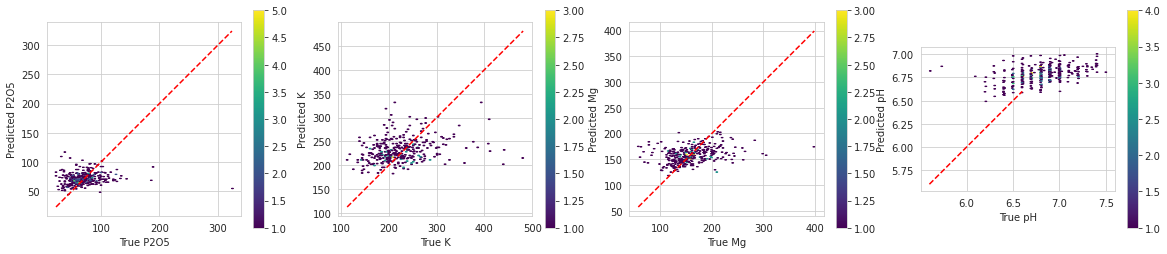

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.set_aspect('equal')

    img = ax.hexbin(y_v[:, i], y_hat[:, i], cmap='viridis', mincnt=1)

    ax.plot(np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])),
            np.arange(np.min(y_v[:, i]), np.max(y_v[:, i])), 'r--')

    plt.colorbar(img, ax=ax)

    ax.set_xlabel('True ' + cols[i])
    ax.set_ylabel('Predicted ' + cols[i])

In [18]:
X_test = load_data(test_data)
X_test = preprocess(X_test)

predictions = []

for rf in random_forests:
    pp = rf.predict(X_test)
    predictions.append(pp)
    
predictions = np.asarray(predictions)
print(predictions.shape)

predictions = np.mean(predictions, axis=0)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")

(5, 1154, 4)


In [19]:
submission

,P,K,Mg,pH
0,71.7178,230.020,161.6368,6.86946
1,69.4510,235.466,180.4612,6.91828
2,64.8914,215.090,162.6458,6.87824
3,92.0014,264.596,180.0638,6.85336
4,73.6512,225.166,161.1938,6.93060
...,...,...,...,...
1149,60.3086,193.354,146.5596,6.68606
1150,59.4920,198.624,142.1098,6.62514
1151,67.6988,218.148,159.9886,6.73468
1152,58.5952,198.008,144.4318,6.64698
